# FisherFaces

## Step 1: Preprocess the images

### Load the images

In [1]:
import bz2
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
directory = 'feret/'
faces = {}
person_face = {} # to store one image for each person
num_of_faces_loaded = 20 #change this value to adjust the number of faces to be loaded


for index, person_id in enumerate(os.listdir(directory)):
    if index > num_of_faces_loaded:
        break

    person_path = os.path.join(directory, person_id)
    
    if os.path.isdir(person_path):
        for image_id in os.listdir(person_path):
            image_path = os.path.join(person_path, image_id)

            if image_path.endswith(".ppm.bz2"):
                with bz2.BZ2File(image_path, 'rb') as f:
                    content = f.read()
                image = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_GRAYSCALE)

                file_path = "/".join(image_path.split("/")[1:])
                faces[file_path] = image
                person_face[file_path.split("/")[0]] = image

### Let's see some of them

Showing sample faces


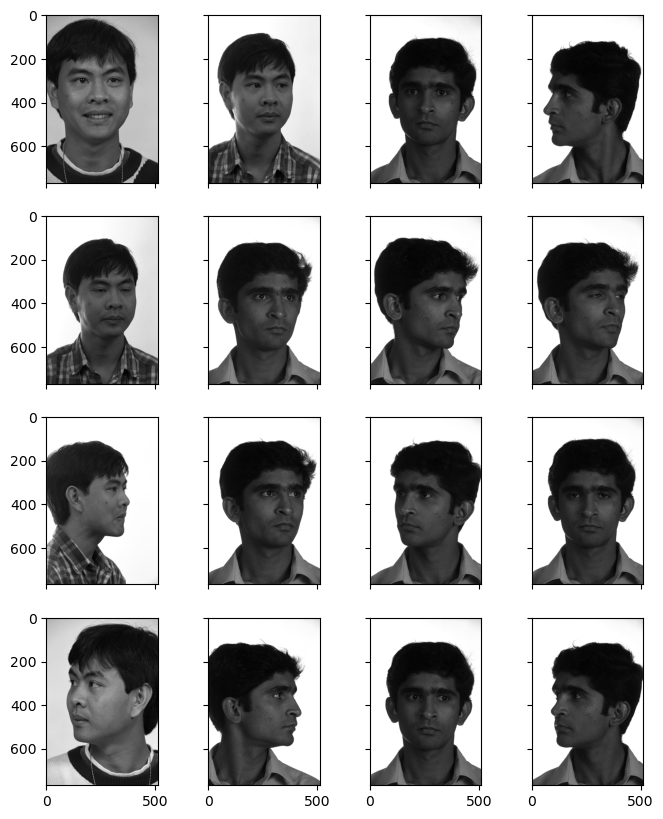

In [3]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:]
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

### Some details about the data

In [4]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Face image shape: (768, 512)
Number of classes: 21
Number of images: 239


### Split the data into training and test data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
facematrix = []
facelabel = []
for key,val in faces.items():
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

facematrix = np.array(facematrix)
facelabel = np.array(facelabel)

In [7]:
Xtr, Xts, ytr, yts = train_test_split(facematrix, facelabel, test_size=0.25, stratify = facelabel)

## Step 2: Training

### Extract the most descriminative features using PCA

##### We use only the most descriminative features because otherwise Sw and Sb will be too large and it will result in MemoryError

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=100)
Xtr_pca = pca.fit_transform(Xtr)
Xts_pca = pca.transform(Xts)

### Compute Sw and Sb

In [10]:
def within_class_scatter_matrix(X, y):
    num_features = X.shape[1]
    classes = np.unique(y)
    Sw = np.zeros((num_features, num_features))


    class_means = [np.mean(X[y == c], axis=0) for c in classes]

    for c, class_mean in zip(classes, class_means):
        X_c = X[y == c]

        scatter_matrix = np.zeros((num_features, num_features))
        for x in X_c:
            x_minus_mean = x - class_mean
            scatter_matrix += np.outer(x_minus_mean, x_minus_mean)

        Sw += scatter_matrix

    return Sw


def between_class_scatter_matrix(X, y):
    num_features = X.shape[1]
    classes = np.unique(y)
    Sb = np.zeros((num_features, num_features))

    overall_mean = np.mean(X, axis=0)

    for c in classes:
        X_c = X[y == c]

        class_mean = np.mean(X_c, axis=0)
        mean_diff = class_mean - overall_mean

        Sb += len(X_c) * np.outer(mean_diff, mean_diff)

    return Sb

In [11]:
from scipy.linalg import eig

In [12]:
Sw = within_class_scatter_matrix(Xtr_pca, ytr)
Sb = between_class_scatter_matrix(Xtr_pca, ytr)

eigenvalues, eigenvectors = eig(Sw, Sb)


### Create a fisherface matrix (LDA space)

In [13]:
fisherface_matrix = eigenvectors[:, :100]

### Project the data into the LDA space (fisherface matrix)

In [14]:
Xtr_fisher = Xtr_pca.dot(fisherface_matrix)
Xts_fisher = Xts_pca.dot(fisherface_matrix)

# Step 3: Classification

## KNearestClassifier

In [15]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]

        k_indices = np.argsort(distances)[:self.k]


        k_nearest_labels = [self.y_train[i] for i in k_indices]

        int_to_str_map = {int(label): label for label in k_nearest_labels}


        most_common = np.bincount(k_nearest_labels).argmax()
        return int_to_str_map[most_common]

# Test

#### Accuracy calculator

In [16]:
def check_accuracy(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Input lists must have the same length.")

    correct = 0
    total = len(y_true)

    for true_label, predicted_label in zip(y_true, y_pred):
        if true_label == predicted_label:
            correct += 1

    accuracy = (correct / total) * 100
    return accuracy, correct

### Let's test the algorithm on the test set

In [17]:
num_of_test = 10
classifier = KNNClassifier(k = 1)
classifier.fit(Xtr_fisher, ytr)

predictions = classifier.predict(Xts_fisher)

### Let's see some of the predictions

Test Image :0
Best Match: 00736


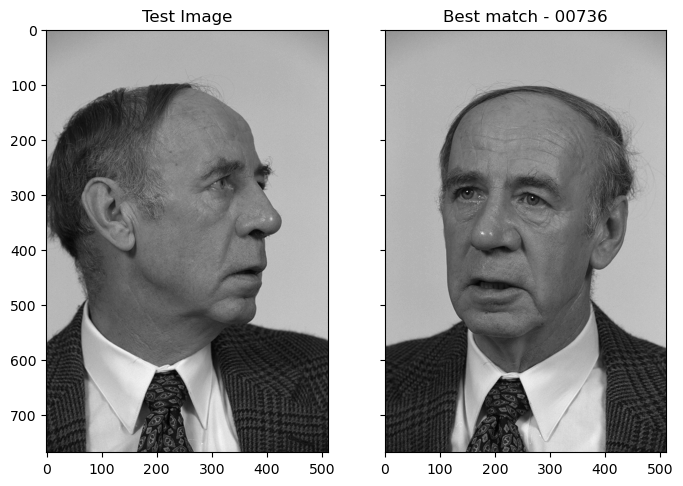

Test Image :1
Best Match: 00642


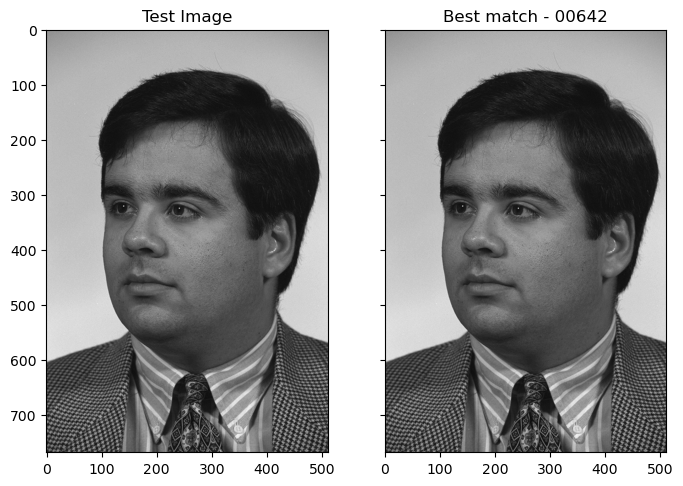

Test Image :2
Best Match: 00736


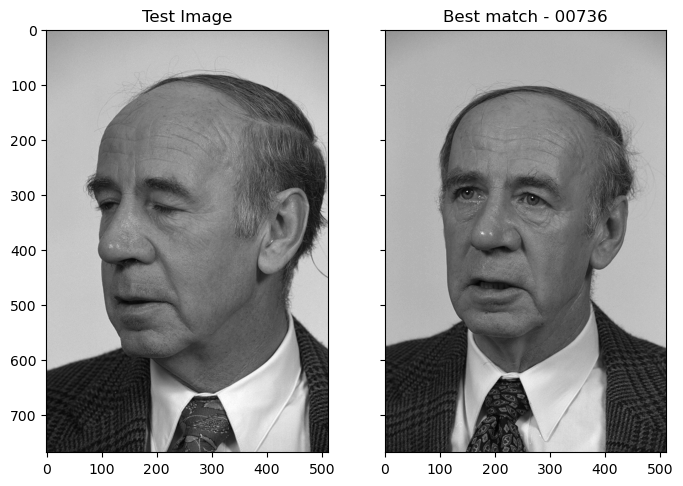

Test Image :3
Best Match: 00642


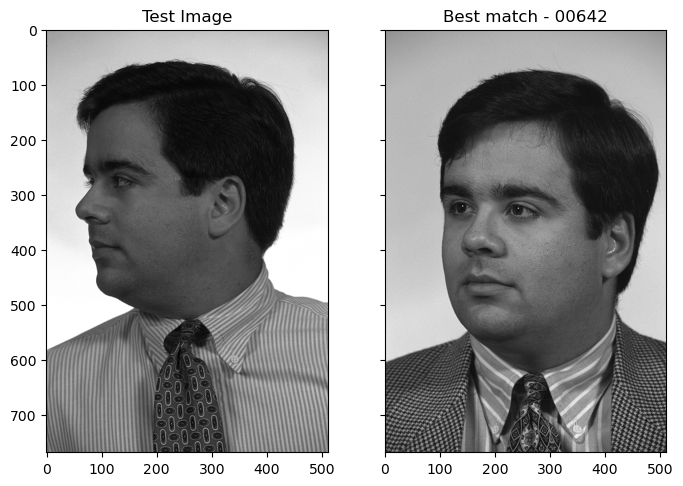

Test Image :4
Best Match: 00324


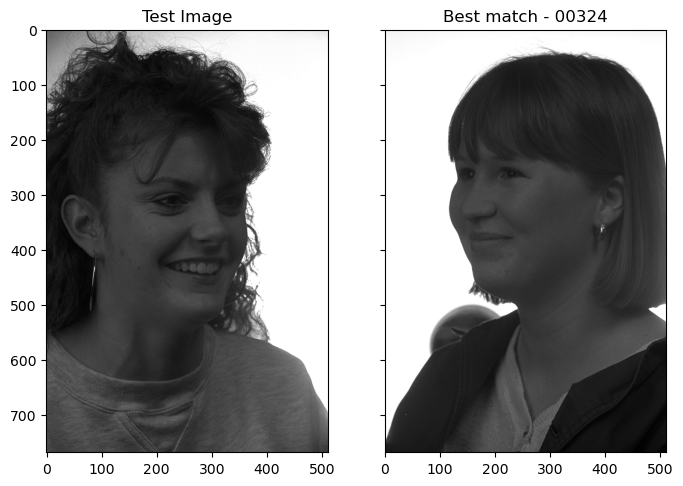

Test Image :5
Best Match: 00737


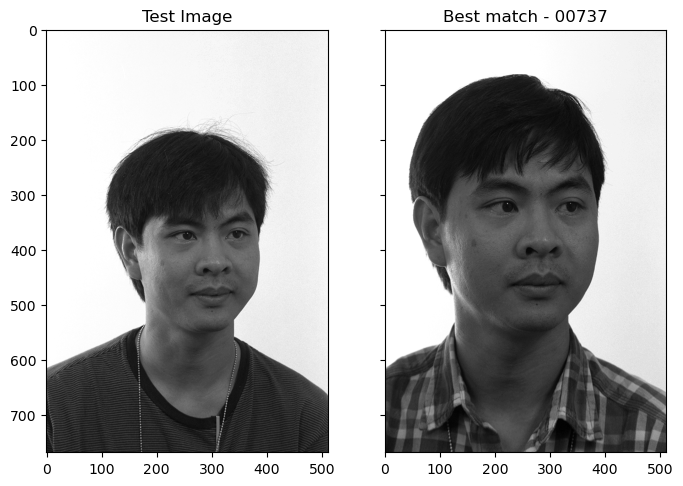

Test Image :6
Best Match: 00737


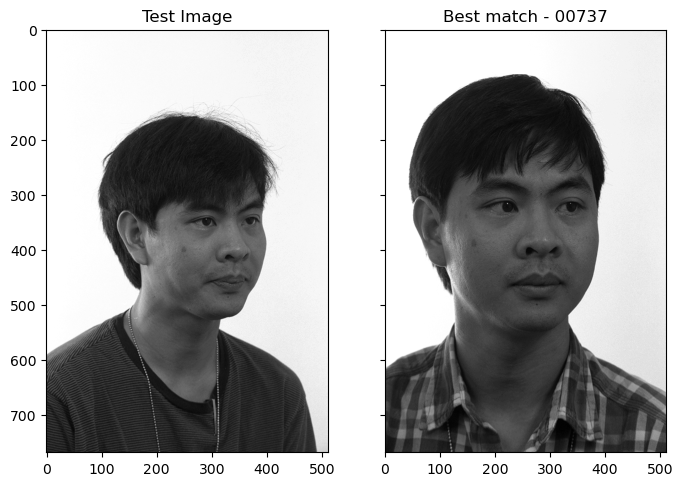

Test Image :7
Best Match: 00499


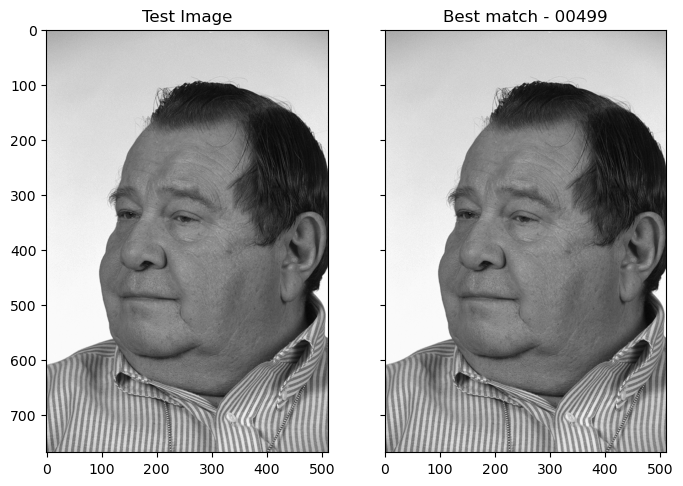

Test Image :8
Best Match: 00324


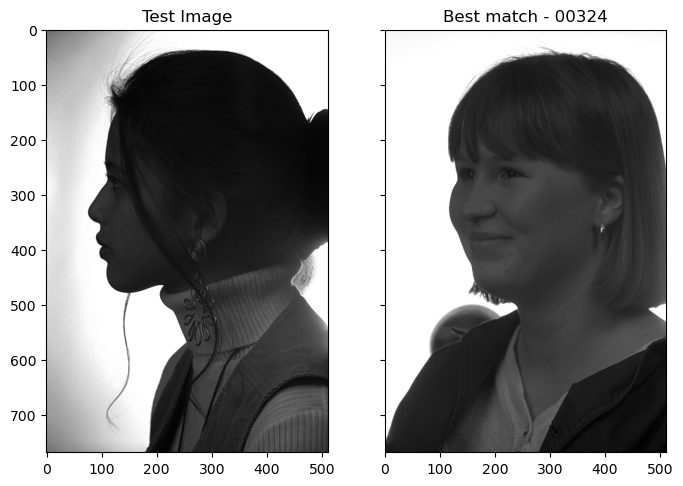

Test Image :9
Best Match: 00630


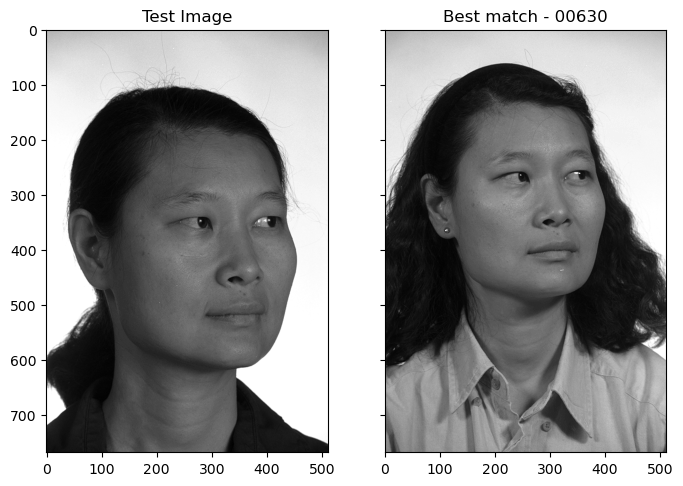

In [18]:
num_of_test = 10 #change this to adjust the number of pictures being shown
for i in range(num_of_test):

    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(Xts[i].reshape(faceshape), cmap="gray")
    axes[0].set_title(f"Test Image")

    print(f"Test Image :{i}\nBest Match: {predictions[i]}")
    axes[1].imshow(person_face[predictions[i]].reshape(faceshape), cmap="gray")
    axes[1].set_title(f"Best match - {predictions[i]}")
        

    plt.show()

### Check the accuracy

In [19]:
accuracy, correct = check_accuracy(yts, predictions)

print(f"{correct} correct guesses out of {len(yts)}")
print(f"Accuracy: {accuracy}")

49 correct guesses out of 60
Accuracy: 81.66666666666667
